# Wage Differences Within The STEM Occupation #

## Introduction ##

In recent years, both the consumer price index (CPI) and real gross domestic product (RGDP) have been increasing, indicating a boom in the economy (Canada, 2023). Therefore, we would also expect an increase in wages in all industries to a certain extent. Meanwhile, the rapid global growth in the field of Science, Technology, Engineering, and Mathematics (STEM) since 2020 globally has attracted many people to the industry (O’Rourke, 2021). Canada, being one of the more developed countries has also been greatly impacted. There has been an increase in students that are pursuing STEM. This leads us to the question we want to investigate: **Are hourly wages for workers with STEM occupations between ages 20-24 lower than workers between the ages of 40-44?** We will be looking at the Labour Force Survey, 2023 (LFS) data set from Statistic Canada. The survey was conducted in the first quarter of 2023 and includes information about the immigration status, hourly wage, field of occupation and other information of the workers. 

## Methods and Results ##

In [50]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
require(gridExtra)

In [5]:
options(repr.plot.width=20, repr.plot.height=10) # Setting options

The following code imports the April 2023 Canadian Labour Force data into the notebook.

In [6]:
employment <- read_csv("https://raw.githubusercontent.com/GWilliam02/STAT201-Project/main/data/employmentData.csv")

Rows: 108064 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): SURVMNTH, AGE_12, NAICS_21, NOC_10, NOC_43, WHYLEFTN, EFAMTYPE
dbl (53): REC_NUM, SURVYEAR, LFSSTAT, PROV, CMA, AGE_6, SEX, MARSTAT, EDUC, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
employment_clean <- employment |>
                    select(NOC_10 ,HRLYEARN,AGE_12) |>
                    filter(!is.na(HRLYEARN)) |>
                    filter(NOC_10 == "03") |>    #Filters out everyone with STEM Occupations
                    filter(AGE_12=="02"|AGE_12=="06") |>
                    select(-NOC_10) |>
                    rename(age_group = AGE_12,
                          hourly_wage = HRLYEARN) |>
                    mutate(age_group = case_when(age_group == "02" ~ "20 to 24yr old",
                                                         age_group == "06" ~ "40 to 44 yr old")
                          ,hourly_wage = hourly_wage/100)
                    
                

head(employment_clean)

hourly_wage,age_group
<dbl>,<chr>
28.85,40 to 44 yr old
76.92,40 to 44 yr old
46.00,40 to 44 yr old
35.90,40 to 44 yr old
32.21,40 to 44 yr old
25.00,20 to 24yr old


**Table 1: Hourly wages and age group of an indvidual**

In [11]:
data_summary <- tibble(initial_dataframe_size = nrow(employment), size_after_cleaning = nrow(employment_clean))

summary_stats <- employment_clean |>
                group_by(age_group) |>
                summarize(count = n(), 
                         mean_wage = mean(hourly_wage),
                         sd = sd(hourly_wage),
                         variance = var(hourly_wage))
data_summary

initial_dataframe_size,size_after_cleaning
<int>,<int>
108064,806


**Table 2: Cleaned dataframe size**

In [42]:
summary_stats

age_group,count,mean_wage,sd
<chr>,<int>,<dbl>,<dbl>
20 to 24yr old,220,26.71486,7.937008
40 to 44 yr old,586,46.05520,16.694721


**Table 3: Summary Statistics of variables of interest**

The raw dataframe contained 108064 respondents in Canada, where each row represents a single participant and their personal information and details on their employment. After data processing, 806 participants with STEM occupations with age groups 20-24 or 40-44 remain in the data set. Preliminary data analysis show a mean hourly wage of CAD 26.71 with a standard deviation of 7.94 for the 220 participants in age group 20-24. However, for the 586 participants in age group 40-44, the mean hourly wage is CAD 46.06 with a standard deviation of 16.69.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



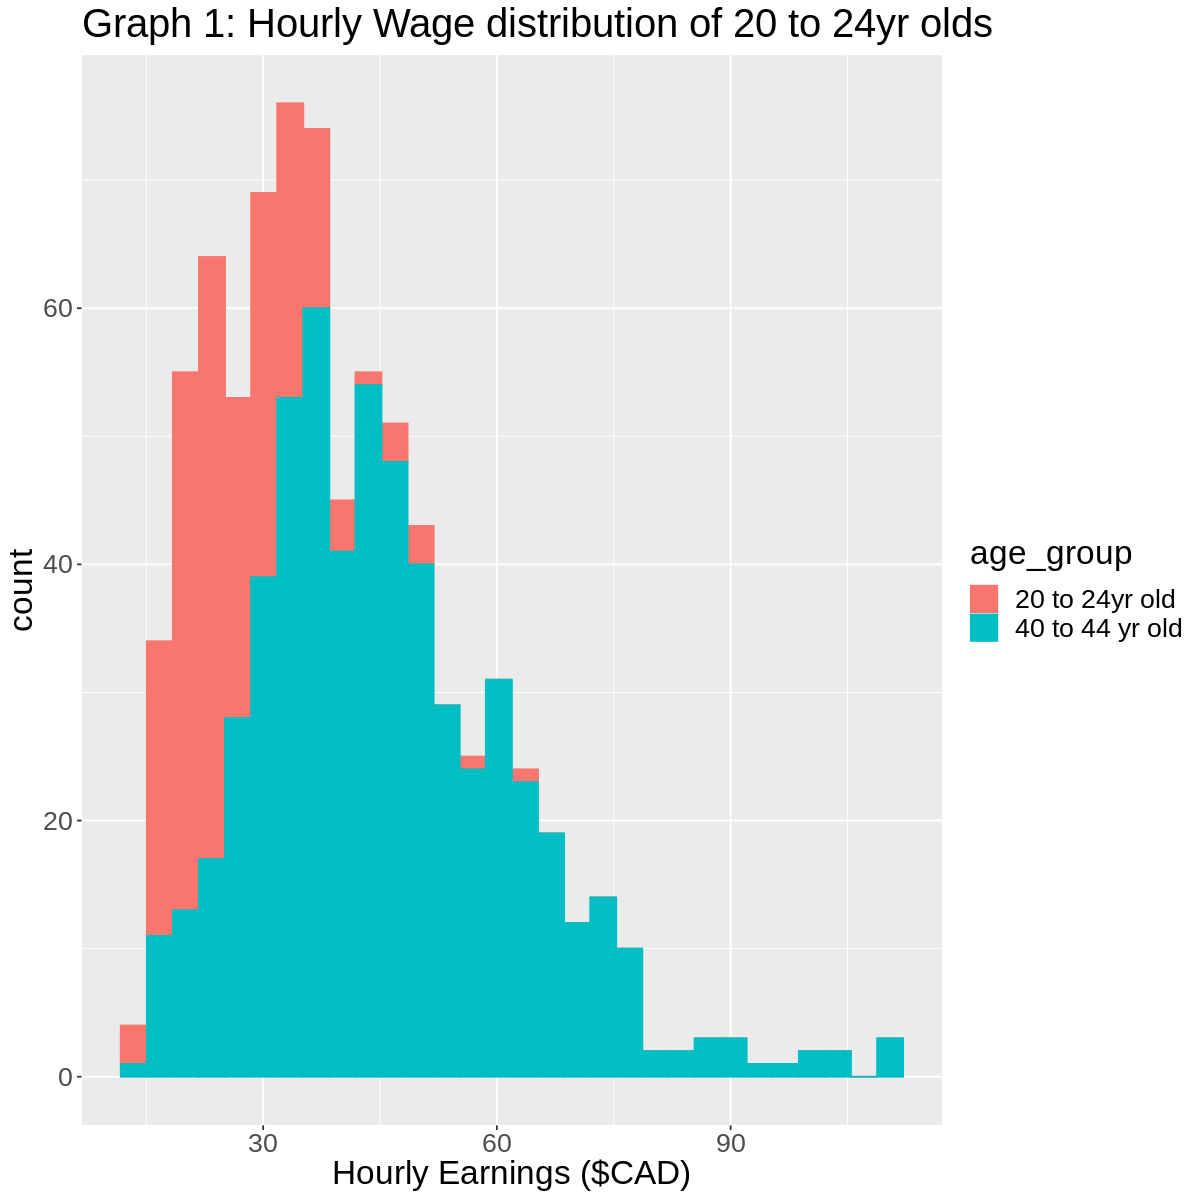

In [44]:
plt_age02 <- employment_clean %>% 
    #filter(age_group == "20 to 24yr old") %>%
    ggplot() +
    geom_histogram(aes(x=hourly_wage,color=age_group,fill=age_group)) +
    ggtitle("Graph 1: Hourly Wage distribution of 20 to 24yr olds") +
    xlab("Hourly Earnings ($CAD)") +
    theme(text = element_text(size = 20))
options(repr.plot.width = 10, repr.plot.height =10)
plt_age02


# plt_age02
# plt_age06
#grid.arrange(plt_age02, plt_age06, ncol=2)

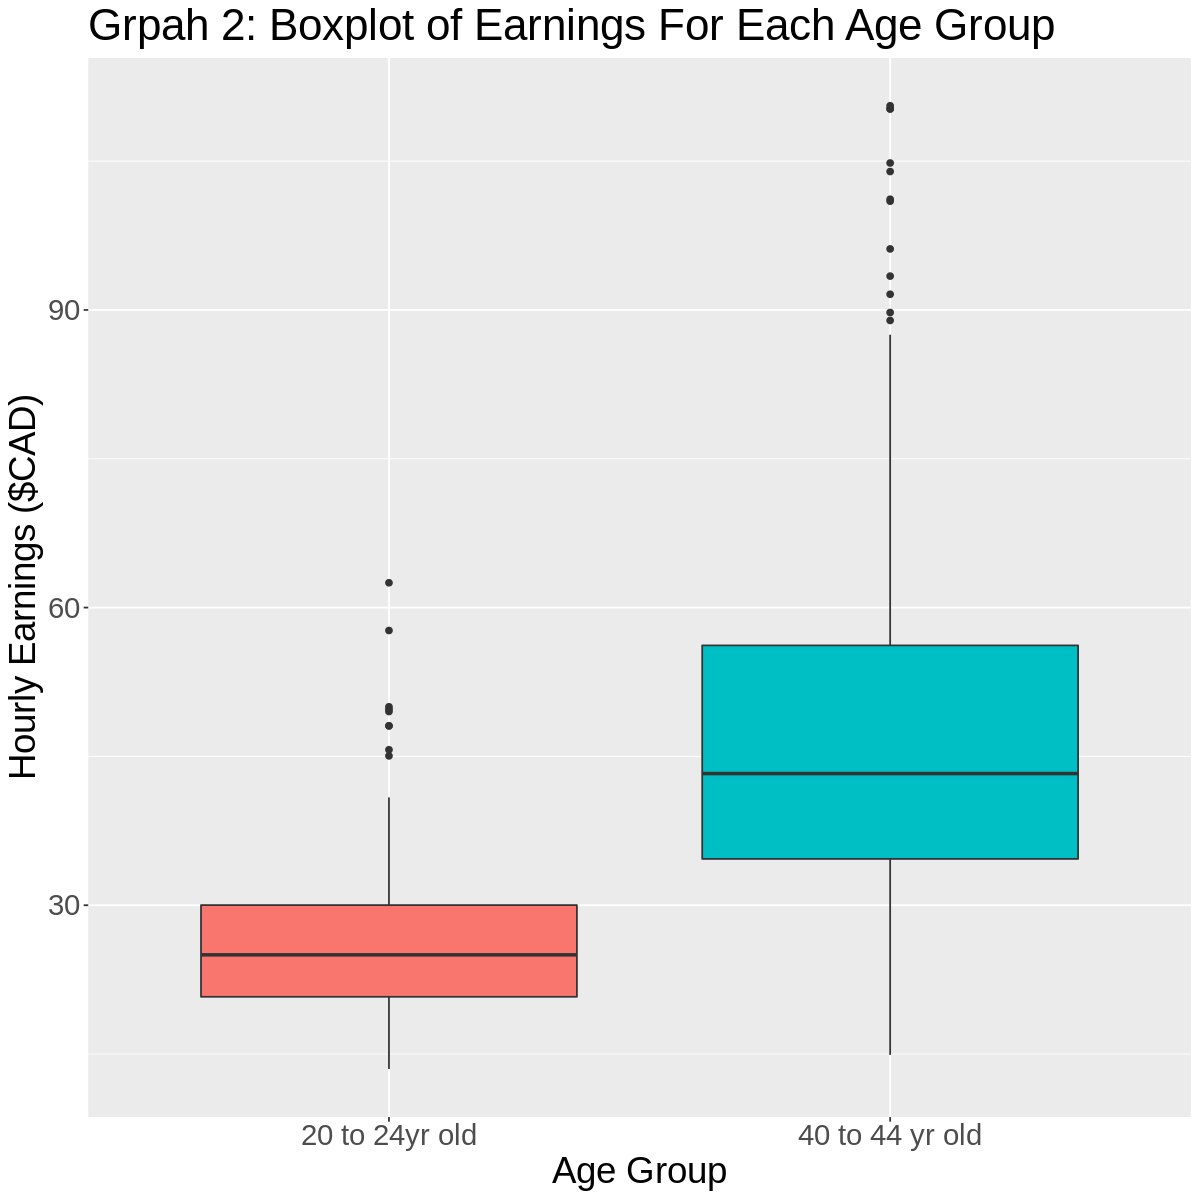

In [45]:
age_vs_wage_boxplots <-
    employment_clean %>% 
    ggplot() +
    geom_boxplot(aes(x=age_group, y=hourly_wage, fill = age_group)) +
    theme(text = element_text(size = 22)) +
    ggtitle("Grpah 2: Boxplot of Earnings For Each Age Group") + 
    xlab("Age Group") + 
    ylab("Hourly Earnings ($CAD)") + 
    guides(fill = "none")
age_vs_wage_boxplots

### Methodology ###

We refer to s1 as the sample of workers in age group 20-24, s2 is the sample with workers in age group 40-44, and μ as the “mean wage”. As this investigation involves two independent datasets of different sizes, the two-sample t-test will be used with the following null hypothesis, $H_0$: $\mu_2$ - $\mu_1$ = 0, and the alternate hypothesis, $H_1: \mu_2 - \mu1 > 0$. By conducting the t-test to obtain the test statistic:

$$
T = \frac{\bar{x}-\bar{y} - d_0}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} }
$$

Along with the degrees of freedom under the null model:

$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
$$

The forementioned test statistics can be used to produce a p-value which will determine the validity of the null hypothesis under a 5% significance level. Visualizations of the t-distribution can be produced with ggplot to approximate the sampling distribution.
Normality was assessed for each age group and visual inspections suggest that both distributions are normal. Hence, the null model is valid for all sample size and we do not need to rely on the CLT. The test will be conducted Asymptotically. Randomness of data can be ensured as phone call surveys were randomly made to different people to collect information on the occupation and personal information. In terms of independence of data, the responses of each individual age group would not effect the each other. Although some may argue that people with lower income may be less likely to disclose their salary and occupation information and result in a violation of the independence of data, the each individual was surveyed anonymously and independently. It minimized that chance that participants would feel embarrased to disclose their salary information or be effected under a group survey setting. 

 

### Results ###

In [46]:
age20to24 <- employment_clean %>% 
    filter(age_group == "20 to 24yr old")

age40to44 <- employment_clean %>% 
    filter(age_group == "40 to 44 yr old")

xbar <- mean(age20to24$hourly_wage)
ybar <- mean(age40to44$hourly_wage)

xSd <- var(age20to24$hourly_wage)
ySd <- var(age40to44$hourly_wage)

xn <- length(age20to24$hourly_wage)
yn <- length(age40to44$hourly_wage)

v <- ((xSd/xn)+(ySd/yn))^2 / ((xSd^2/((xn^2)*(xn-1)) + ySd^2/((yn^2)*(yn-1))))


T <- (xbar-ybar)/sqrt(xSd/xn+ySd/yn)
cat("T value:",T)


T value: -22.15625

In [47]:
se = sqrt((xSd/xn)+(ySd/yn))

age_mean_ci <- tibble(lower_ci = (xbar-ybar)-T*se,upper_ci = (xbar-ybar)+T*se)
age_mean_ci

lower_ci,upper_ci
<dbl>,<dbl>
0,-38.68068


**Table 4: Confidance interval**

## Discussion ##

In [49]:
table5 <- data.frame(T_value=T,
                 P_value=pt(T,v,lower.tail=TRUE),
                Lower_Confidance_Interval=age_mean_ci[1],
                 Upper_Confidance_Interval=age_mean_ci[2])
colnames(table1) <- c("T value", "P value","Lower Confidance Interval","Upper Confidance Interval")
table5



T_value,P_value,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
-22.15625,1.153059e-84,0,-38.68068


**Table 5: Summary of results

We expect to find a significant difference between the workers’ incomes of the two age groups, with the older generation having a higher income with a big difference. Industries value work experience, and people of older age having a stronger resume compared to the younger group  being introduced to the workforce. Individuals also gain the opportunity to advance in their company with experience.

### Significance and Impact ###

Knowing the income of different age groups can give insight to the longevity an individual has in the workforce. Our data gives an estimation of how much an individual is worth at their age range. Workers can approximate their value and negotiate their wage accordingly. This aids individuals in recognizing if they’re underpaid in comparison to their counterparts. 

### Future Questions ###

After we conclude on this inferential question, we can further look at more specific questions. Such as: is the difference in hourly wage amongst the age groups constant between different major cities across Canada, or do they deviate? In which we can gain more insights about what types of jobs may largely depend on the experience of individuals. Moreover, many students choose to enter a trade workforce coming out of high school. They are likely to enter the workforce faster than university students and gain more experience.  How do the wages compare between workers in trades and workers in STEM across different age groups? Additionally, many higher level jobs pay by salary and don’t have set work hours, which doesn’t account for a portion of the population. Is the difference in salary significant amongst these age groups? 


## References ##

Canada,. (2023). The Daily — Consumer Price Index, June 2023. Statcan.gc.ca. https://www150.statcan.gc.ca/n1/daily-quotidien/230718/dq230718a-eng.htm?HPA=1&indid=3665-1&indgeo=0  


O’Rourke, B. (2021, November 18). Increasing access and opportunity in STEM crucial, say experts. Harvard Gazette; Harvard Gazette. https://news.harvard.edu/gazette/story/2021/11/increasing-access-and-opportunity-in-stem-crucial-say-experts/


Tilo, Dexter. “31% of Canadians Have Never Tried to Negotiate Salary.” HRD Canada, 22 July 2022, www.hcamag.com/ca/specialization/employment-law/31-of-canadians-have-never-tried-to-negotiate-salary/414171. https://www.hcamag.com/ca/specialization/employment-law/31-of-canadians-have-never-tried-to-negotiate-salary/414171